In [1]:
# Installing the dependencies in our virtual environment.
# Please note that we will be using Tensorflow 2.4.1 which requires python 3.6 - 3.8. So, here we use python 3.7.3
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

  Using cached tensorflow_gpu-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached matplotlib-3.4.3-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached Pillow-8.4.0-cp37-cp37m-win_amd64.whl (3.2 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-win_amd64.whl (51 kB)


In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import uuid
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Now, let's make the above directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [8]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

(480, 640, 3)
(250, 250, 3)


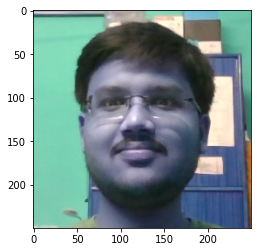

In [61]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     cv2.imshow('Image Collection', frame)
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()
# plt.imshow(frame[115:115+250, 195:195+250, :])
# print(frame.shape)
# print(frame[115:115+250, 195:195+250, :].shape)

In [63]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down the frame to 250x250px
    frame = frame[115:115+250, 195:195+250, :]
    
    # Collect Anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Writeout anchor image
        cv2.imwrite(imgname, frame)
        
    # Collect Positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Writeout positive image
        cv2.imwrite(imgname, frame)
        
    cv2.imshow('Image Collection', frame)
        
    # Breaking out
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
    
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [6]:
# Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(780)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(780)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(780)

In [7]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Return image
    return img

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [10]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [11]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [12]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [13]:
# Build Embedding Layer

def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [14]:
embedding = make_embedding()

In [15]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [16]:
# Siamese L1 Distance class

class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [17]:
siamese_layer = L1Dist()

In [18]:
# Make Siamese Model

def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [19]:
siamese_model = make_siamese_model()

In [20]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [21]:
# Training

# Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [22]:
opt = tf.keras.optimizers.Adam(1e-4)

In [23]:
# Establish Checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [24]:
# Build Train Step Function

@tf.function
def train_step(batch):
    
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        x = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

In [25]:
# Build Training Loop

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [26]:
# Train the model
train(train_data, 50)


 Epoch 1/50
69/69 [==============================] - 39s 241ms/step

 Epoch 2/50
69/69 [==============================] - 16s 240ms/step

 Epoch 3/50
69/69 [==============================] - 16s 236ms/step

 Epoch 4/50
69/69 [==============================] - 16s 239ms/step

 Epoch 5/50
69/69 [==============================] - 16s 239ms/step

 Epoch 6/50
69/69 [==============================] - 16s 239ms/step

 Epoch 7/50
69/69 [==============================] - 16s 238ms/step

 Epoch 8/50
69/69 [==============================] - 16s 239ms/step

 Epoch 9/50
69/69 [==============================] - 16s 236ms/step

 Epoch 10/50
69/69 [==============================] - 16s 235ms/step

 Epoch 11/50
69/69 [==============================] - 16s 238ms/step

 Epoch 12/50
69/69 [==============================] - 16s 236ms/step

 Epoch 13/50
69/69 [==============================] - 16s 233ms/step

 Epoch 14/50
69/69 [==============================] - 16s 232ms/step

 Epoch 15/50
69/69 [========

In [27]:
# Evaluate model
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [28]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [29]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.0000000e+00],
       [1.0000000e+00],
       [1.5182232e-07],
       [9.9999571e-01],
       [9.9998510e-01],
       [7.9987614e-11],
       [2.6540718e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.4229617e-07],
       [1.0000000e+00],
       [9.9999964e-01],
       [6.5798048e-14],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.8600187e-09]], dtype=float32)

In [30]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]

In [31]:
y_true

array([1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [32]:
# Calculate metrics
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [33]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

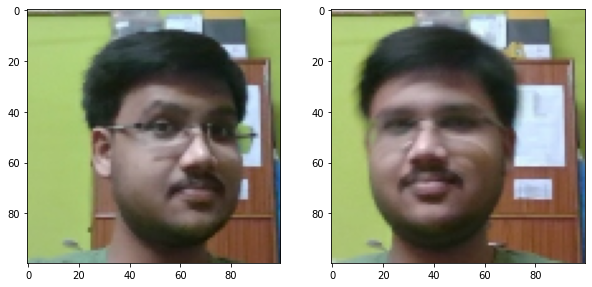

In [34]:
# Viz Results
# Set plot size
plt.figure(figsize=(10, 8))

# Set first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [35]:
# Save Model

# Save weights
siamese_model.save('siamesemodel.h5')

In [36]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [37]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[1.0000000e+00],
       [1.0000000e+00],
       [1.5182232e-07],
       [9.9999571e-01],
       [9.9998510e-01],
       [7.9987614e-11],
       [2.6540718e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.4229617e-07],
       [1.0000000e+00],
       [9.9999964e-01],
       [6.5798048e-14],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.8600187e-09]], dtype=float32)

In [38]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [39]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [40]:
tf.test.is_built_with_cuda()

True

In [41]:
print(tf.version.VERSION)

2.4.1
